# TP3 - Exercício 2
## Grupo 1

*   Diogo Coelho da Silva A100092
*   Pedro Miguel Ramôa Oliveira A97686

**Problema proposto:**
Relativo ao programa do problema anterior,

 1. Construa um “Control Flow Automaton (CFA)” que determina este programa. Identifique os locais e as transições/ramos.  Numa abordagem orientada às pré-condições  identifique os transformadores de predicados associados aos vários locais e os “switches” associados aos vários ramos. 
 2. Construa em `z3` o sistema de equações que representa o comportamento deste sistema dinâmico sob o ponto de vista da prova de segurança e verifique a segurança do programa através da resolução (total ou parcial) deste sistema.
    > sugere-se (não é obrigatório mas é valorizado !), na alínea (a), uma representação do CFA através de  um grafo orientado  implementado  em `networkx`  e a sua compilação para o sistema de equações.





**Proposta de resolução:**
O problema apresentado tem como objetivo a criação de SFOTS para descrever o comportamento de um programa, neste caso o algoritmo de Euclides.
Na solução apresentada o sistema finito de transições foi definido utilizando BitVectors de tamanho n(32 no caso da nossa solução, para garantir a representação de números inteiros em 32 bits). Para verificar que o programa nunca atinge um estado de erro, utilizamos prova por interpolantes e invariantes,com a k-indução.
Foram também considerados as restrições e variáveis dadas no enunciado do problema.

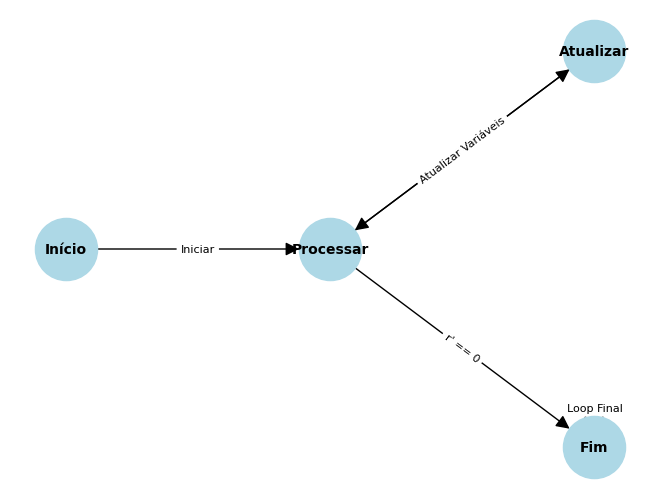

In [11]:
import networkx as nx
from pysmt.shortcuts import Symbol, And, Equals, Not, BV, BVUGT, BVType, SBV
from pysmt.typing import BOOL

n = 32  # Número de bits das variáveis

def declare_cfa_vars():
    return {
        "r": Symbol("r", BVType(n)),
        "r_": Symbol("r_", BVType(n)),
        "s": Symbol("s", BVType(n)),
        "s_": Symbol("s_", BVType(n)),
        "t": Symbol("t", BVType(n)),
        "t_": Symbol("t_", BVType(n)),
        "q": Symbol("q", BVType(n)),
        "pc": Symbol("pc", BVType(n))
    }

def init_cfa(vars, a, b):
    return And(
        Equals(vars["r"], BV(a, n)),
        Equals(vars["r_"], BV(b, n)),
        Equals(vars["s"], BV(1, n)),
        Equals(vars["s_"], BV(0, n)),
        Equals(vars["t"], BV(0, n)),
        Equals(vars["t_"], BV(1, n)),
        Equals(vars["pc"], BV(0, n))
    )

def cfa_transitions(vars):
    transitions = []
    
    # Estado 0 -> Estado 1
    t01 = And(
        Equals(vars["pc"], BV(0, n)),
        Equals(vars["pc"], BV(1, n))
    )
    transitions.append(t01)

    # Estado 1 -> Estado 2 (quando r_ != 0)
    t12 = And(
        Equals(vars["pc"], BV(1, n)),
        Not(Equals(vars["r_"], BV(0, n))),
        Equals(vars["pc"], BV(2, n))
    )
    transitions.append(t12)

    # Estado 2 -> Estado 1 (atualiza variáveis)
    t21 = And(
        Equals(vars["pc"], BV(2, n)),
        Equals(vars["pc"], BV(1, n)),
        Equals(vars["q"], BV(vars["r"].bv_signed_value() // vars["r_"].bv_signed_value(), n)),
        Equals(vars["r_"], vars["r"] - vars["q"] * vars["r_"]),
        Equals(vars["s_"], vars["s"] - vars["q"] * vars["s_"]),
        Equals(vars["t_"], vars["t"] - vars["q"] * vars["t_"]),
        Equals(vars["r"], vars["r_"]),
        Equals(vars["s"], vars["s_"]),
        Equals(vars["t"], vars["t_"])
    )
    transitions.append(t21)

    # Estado 1 -> Estado 3 (quando r_ == 0)
    t13 = And(
        Equals(vars["pc"], BV(1, n)),
        Equals(vars["r_"], BV(0, n)),
        Equals(vars["pc"], BV(3, n))
    )
    transitions.append(t13)

    # Estado 3 -> Estado 3 (loop final)
    t33 = And(
        Equals(vars["pc"], BV(3, n)),
        Equals(vars["pc"], BV(3, n))
    )
    transitions.append(t33)

    return transitions

def create_cfa_graph():
    G = nx.DiGraph()

    # Adicionar estados com rótulos
    G.add_node(0, label="Início")
    G.add_node(1, label="Processar")
    G.add_node(2, label="Atualizar")
    G.add_node(3, label="Fim")

    # Adicionar transições
    G.add_edge(0, 1, label="Iniciar")
    G.add_edge(1, 2, label="r' != 0")
    G.add_edge(2, 1, label="Atualizar Variáveis")
    G.add_edge(1, 3, label="r' == 0")
    G.add_edge(3, 3, label="Loop Final")

    return G

def draw_cfa_graph(G):
    pos = {
        0: (0, 1),
        1: (1, 1),
        2: (2, 1.5),
        3: (2, 0.5),
    }
    labels = nx.get_edge_attributes(G, "label")
    node_labels = nx.get_node_attributes(G, "label")

    nx.draw(
        G, pos, with_labels=True, labels=node_labels,
        node_color="lightblue", node_size=2000, font_size=10,
        font_weight="bold", arrowsize=20, arrowstyle="-|>"
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)
    plt.show()

# Criar e desenhar o CFA
G = create_cfa_graph()
draw_cfa_graph(G)


In [12]:
from z3 import *

# Tamanho dos inteiros (exemplo: 32 bits)
n = 32

# Declaração das variáveis
a = BitVec("a", n)
b = BitVec("b", n)
r = BitVec("r", n)
r_ = BitVec("r_", n)
s = BitVec("s", n)
s_ = BitVec("s_", n)
t = BitVec("t", n)
t_ = BitVec("t_", n)
q = BitVec("q", n)

# Sistema de transições
transitions = []

# Inicialização
init = And(
    r == a, r_ == b,
    s == 1, s_ == 0,
    t == 0, t_ == 1
)
transitions.append(init)

# Transição 1: Enquanto r' != 0
loop_cond = And(r_ != 0)

# Atualização das variáveis no loop
update = And(
    q == r / r_,
    r == r_,
    r_ == r - q * r_,
    s == s_,
    s_ == s - q * s_,
    t == t_,
    t_ == t - q * t_
)
transitions.append(Implies(loop_cond, update))

# Transição 2: Quando r' == 0 (fim do programa)
end = And(r_ == 0)
transitions.append(end)

# Verificação da segurança do programa
solver = Solver()

# Garantir que o GCD seja mantido
gcd_property = And(
    r == a * s + b * t,  # Garantir relação a*s + b*t = r
    Implies(end, r > 0)  # GCD é maior que zero
)

solver.add(init)
solver.add(ForAll([a, b], gcd_property))

# Resolver
if solver.check() == sat:
    print("O programa é seguro.")
    print(solver.model())
else:
    print("A segurança do programa não pôde ser verificada.")


A segurança do programa não pôde ser verificada.
